# Data preprocessing

Here we explore the data for different processing steps. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.random.seed(42)

Define the path to the input data.

In [2]:
PATH_AMP_POSITIVE = "../data/raw/amp_positive.csv"
PATH_AMP_NEGATIVE = "../data/raw/amp_negative.csv"

Here are the preprocessing options.

In [3]:
REMOVE_METHIONINE_PREFIX = True

MIN_LENGTH = 8
MAX_LENGTH = 35

OUTPUT_PATH = f"../data/processed/amp_{MIN_LENGTH}_{MAX_LENGTH}.csv"

In [4]:
df_amp_pos = pd.read_csv(PATH_AMP_POSITIVE)
df_amp_neg = pd.read_csv(PATH_AMP_NEGATIVE)

df_amp_pos.columns = [col.lower() for col in df_amp_pos.columns]
df_amp_pos["sequence_length"] = [len(seq) for seq in df_amp_pos["sequence"]]
df_amp_pos["is_amp"] = 1

df_amp_neg.columns = [col.lower() for col in df_amp_neg.columns]
df_amp_neg["sequence_length"] = [len(seq) for seq in df_amp_neg["sequence"]]
df_amp_neg["is_amp"] = 0

print(f"AMP-pos seqs: {df_amp_pos.shape[0]}")
print(f"AMP-neg seqs: {df_amp_neg.shape[0]}")

AMP-pos seqs: 20313
AMP-neg seqs: 25762


Remove first letter if it is Methionine (M).

In [5]:
amp_pos_m_prefix = df_amp_pos["sequence"].str.startswith("M")
amp_neg_m_prefix = df_amp_neg["sequence"].str.startswith("M")

print(f"AMP-pos with M prefix: {amp_pos_m_prefix.sum() / df_amp_pos.shape[0]*100:.2f}%")
print(f"AMP-neg with M prefix: {amp_neg_m_prefix.sum() / df_amp_neg.shape[0]*100:.2f}%")

if REMOVE_METHIONINE_PREFIX:
    df_amp_pos["sequence"] = df_amp_pos["sequence"].apply(lambda x: x[1:] if x.startswith("M") else x)
    df_amp_neg["sequence"] = df_amp_neg["sequence"].apply(lambda x: x[1:] if x.startswith("M") else x)

AMP-pos with M prefix: 11.04%
AMP-neg with M prefix: 95.32%


Filter AMP-pos based on sequence length.

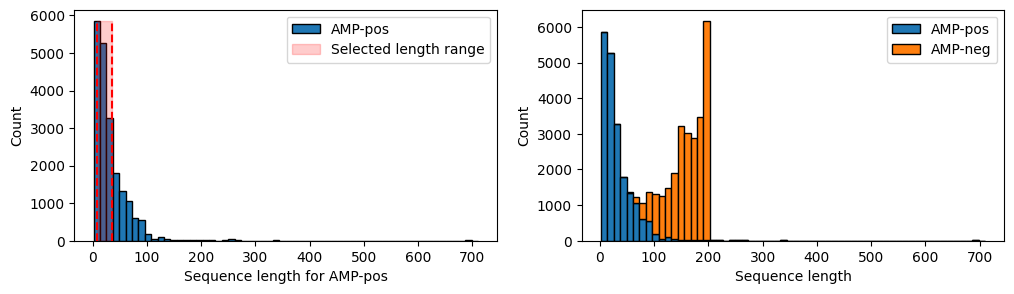

In [6]:
fig, axes = plt.subplots(figsize=(12, 3), ncols=2)

ax = axes[0]
hist_res = ax.hist(
    [df_amp_pos["sequence_length"]],
    stacked=True,
    bins=60,
    edgecolor="black",
    label=["AMP-pos", "AMP-neg"],
)
ax.set_xlabel("Sequence length for AMP-pos")
ax.fill_betweenx(
    [0, hist_res[0].max()],
    MIN_LENGTH,
    MAX_LENGTH,
    color="red",
    alpha=0.2,
    label="Selected length range",
)
ax.vlines(MIN_LENGTH, 0, hist_res[0].max(), color="red", linestyle="--")
ax.vlines(MAX_LENGTH, 0, hist_res[0].max(), color="red", linestyle="--")
ax.set_ylabel("Count")
ax.legend()

ax = axes[1]
hist_res = ax.hist(
    [df_amp_pos["sequence_length"], df_amp_neg["sequence_length"]],
    stacked=True,
    bins=60,
    edgecolor="black",
    label=["AMP-pos", "AMP-neg"],
)
ax.set_xlabel("Sequence length")
ax.set_ylabel("Count")
ax.legend()

In [7]:
m = (df_amp_pos["sequence_length"] >= MIN_LENGTH) & (df_amp_pos["sequence_length"] <= MAX_LENGTH)
print(f"no. of AMP-pos sequences after filtering by sequence-length: {m.sum()} ({m.sum() / df_amp_pos.shape[0]*100:.2f}%)")

df_amp_pos = df_amp_pos[m]

no. of AMP-pos sequences after filtering by sequence-length: 13281 (65.38%)


Subsequence AMP-neg to have the same length distribution as AMP-pos.

In [8]:
def sample_by_frequency(xs, n):
    elements, count = np.unique(xs, return_counts=True)
    probs = count / xs.shape
    return np.random.choice(elements, size=n, p=probs)


amp_neg_subseq_lens = sample_by_frequency(df_amp_pos["sequence_length"], n=df_amp_neg.shape[0])
amp_neg_subseq_lens.sort()

df_amp_neg.sort_values("sequence_length", inplace=True)

In [9]:
def draw_subsequence(sequence, new_length):
    assert new_length <= len(sequence)
    idx = np.random.randint(0, len(sequence) - new_length)
    return sequence[idx : idx + new_length]


def draw_subsequences(sequences, new_lengths):
    return [draw_subsequence(sequence, new_length) for sequence, new_length in zip(sequences, new_lengths)]


subsequence = draw_subsequences(df_amp_neg["sequence"], amp_neg_subseq_lens)
subsequence_len = [len(seq) for seq in subsequence]

df_amp_neg["sequence"] = subsequence
df_amp_neg["sequence_length"] = subsequence_len

In [10]:
df = pd.concat([df_amp_pos, df_amp_neg], ignore_index=True)

Balance the AMP-pos and AMP-neg.

In [14]:
def balance_classes(df, target_col):
    n = df[target_col].value_counts().min()
    return df.groupby(target_col).apply(lambda x: x.sample(n=n)).reset_index(drop=True)


df = balance_classes(df, "is_amp")

/tmp/ipykernel_15983/2334740079.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(target_col).apply(lambda x: x.sample(n=n)).reset_index(drop=True)


Shuffle data.

In [16]:
df = df.sample(frac=1).reset_index(drop=True)

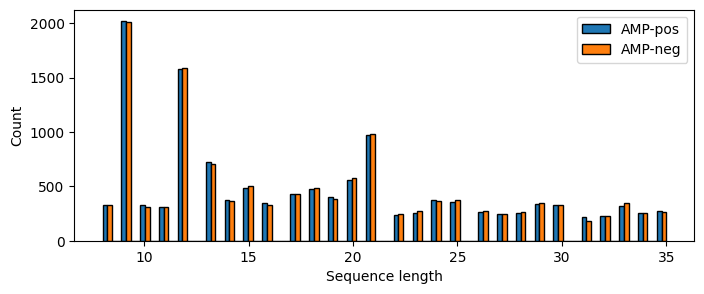

In [18]:
df_amp_pos = df[df["is_amp"] == 1]
df_amp_neg = df[df["is_amp"] == 0]

fig, ax = plt.subplots(figsize=(8, 3))

hist_res = ax.hist(
    [df_amp_pos["sequence_length"], df_amp_neg["sequence_length"]],
    stacked=False,
    bins=60,
    edgecolor="black",
    label=["AMP-pos", "AMP-neg"],
    rwidth=1,
)
ax.set_xlabel("Sequence length")
ax.set_ylabel("Count")
ax.legend()

Save as csv.

In [19]:
df.to_csv(OUTPUT_PATH, index=False)